In [2]:
# Standard library
import os
import sys
import re
import json
import pickle
import glob
import ast
import warnings
from pathlib import Path
import importlib

# Add custom path
sys.path.append('/root/capsule/code/beh_ephys_analysis')

# Scientific libraries
import numpy as np
import pandas as pd
import xarray as xr
import scipy.signal as signal
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# SpikeInterface
import spikeinterface.full as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw

# Progress bar
from tqdm import tqdm

# IPython display
from IPython.display import clear_output

# Open Ephys
from open_ephys.analysis import Session

# AIND analysis and utils
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from aind_ephys_utils import align, sort

# Local utilities
import utils.analysis_funcs as af
import utils.plotting_funcs as pf
from utils.beh_functions import session_dirs
# from utils.plot_utils import shiftedColorMap, template_reorder, plot_raster_bar, merge_pdfs

# Warnings
warnings.filterwarnings("ignore")

# Matplotlib inline for Jupyter
%matplotlib inline

# Confirm version
print(si.__version__)
print('Finished loading packages')


0.102.1
Finished loading packages


In [3]:
# Load antidromic analysis results
result_folder = '/scratch/antidromic'


Number of opto units: 420
['session', 'unit', 'qc_pass', 'opto_tagged', 'opto_tagging_pre', 'opto_tagging_post', 'anti', 'in_df', 'trial_count', 'p_max', 'lat_max_p', 'isi_violations', 'snr', 'eu', 'corr', 'probe', 'y_loc', 'rec_side', 'top', 'bottom']


In [17]:
## Find antidromic unit without plotting
ROI_session = ['behavior_751181_2025-02-27_11-24-47']
for session in folders:
    if session in ROI_session:        
        if session in processed_session_id:
            print(f'{session} already processed')        
        else:
            subject_id = session.split('_')[1]
            print("subject id: ", subject_id)
            print("session: ", session)
            
            # load opto tagging data
            data_type = 'curated'
            target = 'soma'

            data_folder = f'{scratch_data_folder}/{subject_id}/{session}/ephys/opto/curated'
            print("Loading opto tagging data")

            try: 
                with open(os.path.join(data_folder, f'{session}_curated_soma_opto_tagging_summary.pkl'), 'rb') as f:            
                    unit_tbl = pickle.load(f)
            except Exception as e:
                print(f"Skipping {os.path.join(data_folder, f'{session}_curated_soma_opto_tagging_summary.pkl')} due to error: {e}")
                continue
            
            opto_units = unit_tbl.query("opto_pass == True & default_qc == True")["unit_id"].to_list()
            print("opto_units: ", opto_units)
            ## Load spike times

            print("Loading spiketimes")
            # session_dir = session_dirs(session)
            data_type = 'curated'

            try:
                with open(os.path.join(f'{scratch_data_folder}/{subject_id}/{session}/ephys/curated/processed', 'spiketimes.pkl'), 'rb') as f:
                    spiketimes = pickle.load(f)
            except Exception as e:
                print(f"Skipping {os.path.join(data_folder, 'spiketimes.pkl')} due to error: {e}")
                continue

            start = np.min(np.array([np.min(spiketimes[unit]) for unit in spiketimes.keys()]))
            end = np.max(np.array([np.max(spiketimes[unit]) for unit in spiketimes.keys()]))
            # Load opto event data
            opto_event_file = Path(f'{data_folder}/{session}_opto_session.csv')
            event_ids = pd.read_csv(opto_event_file)

            # Unique values
            sites = list(np.unique(event_ids.emission_location))
            powers = list(np.unique(event_ids.power))
            trial_types = np.unique(event_ids.type)

            opto_units = opto_units  # Limit to first 2 units for demonstration
            # Settings
            prepost = 'post'
            num_sites = len(sites)
            num_units = len(opto_units)

            # Create one figure for all units × sites (3 rows per unit: raster + PSTH + antidromic raster)
            fig_height_per_unit = 6
            fig = plt.figure(figsize=(num_sites * 4, num_units * fig_height_per_unit))
            fig.suptitle(f'{session} - Opto responses for {num_units} units', fontsize=16)
            gs = gridspec.GridSpec(4 * num_units, num_sites, height_ratios=[3, 6, 2, 0.5] * num_units, hspace=0.8)

            # Loop through units
            for u_idx, unit_id in enumerate(opto_units):
                if unit_id == 57:
                    unit_spike_times = spiketimes[unit_id]

                    for i, site in enumerate(sites):
                        # Filter trials
                        tag_trials = event_ids.query('site == @site and pre_post == @prepost')
                        max_power = tag_trials.power.max()
                        tag_trials = tag_trials.query('power == @max_power')
                        if tag_trials.empty:
                            continue

                        # Stimulation parameters
                        duration = np.unique(tag_trials.duration)[0]
                        num_pulses = np.unique(tag_trials.num_pulses)[0]
                        pulse_interval = np.unique(tag_trials.pulse_interval)[0]

                        # Time window
                        time_range_raster = np.array([-150 / 1000, 70 / 1000])
                        this_event_timestamps = tag_trials.time.tolist()

                        int_event_locked_timestamps = []
                        pulse_nums = []

                        for pulse_num in range(num_pulses):
                            time_shift = pulse_num * (duration + pulse_interval) / 1000
                            this_time_range = time_range_raster + time_shift

                            this_locked = af.event_locked_timestamps(
                                unit_spike_times, this_event_timestamps, this_time_range, time_shift=time_shift
                            )
                            int_event_locked_timestamps.extend(this_locked)
                            pulse_nums.extend([pulse_num + 1] * len(this_locked))

                        # Raster plot
                        ax_raster = fig.add_subplot(gs[4 * u_idx, i])
                        pf.raster_plot(int_event_locked_timestamps, time_range_raster, cond_each_trial=pulse_nums, ms=100, ax=ax_raster)

                        # Add laser pulse patch
                        yLims = np.array(ax_raster.get_ylim())
                        laser_color = 'tomato'
                        rect = patches.Rectangle((0, yLims[0]), duration / 1000, yLims[1] - yLims[0],
                                                linewidth=1, edgecolor=laser_color, facecolor=laser_color,
                                                alpha=0.2, clip_on=True)
                        ax_raster.add_patch(rect)

                        # Raster axis settings
                        if i == 0:
                            ax_raster.set_ylabel(f'Unit {unit_id}\nPulse #')
                        else:
                            ax_raster.set_yticklabels([])

                        ax_raster.set_xlim(time_range_raster)
                        if u_idx == num_units - 1:
                            ax_raster.set_xlabel('Time (s)')
                        ax_raster.set_title(f'{site}, {max_power} mW')


                        # Add laser pulse aligned but sorted by spike times
                        # Antidromic raster plot
                        ax_antidromic = fig.add_subplot(gs[4 * u_idx + 1, i], sharex=ax_raster)
                        sorted_data = sorted(int_event_locked_timestamps, key=lambda x: (len(x) == 0, x[0] if len(x) > 0 else np.inf))
                        if i==2:
                            ROI_sorted_data = sorted_data 

                        pf.raster_plot(sorted_data, time_range_raster)
                        # pf.raster_plot(sorted_data, time_range_raster, ax=ax_antidromic)

                        yLims = np.array(ax_antidromic.get_ylim())
                        rect = patches.Rectangle((0, yLims[0]), duration / 1000, yLims[1] - yLims[0],
                                                linewidth=1, edgecolor='tomato', facecolor='tomato',
                                                alpha=0.2, clip_on=False)
                        ax_antidromic.add_patch(rect)

                        ax_antidromic.set_xlim(time_range_raster)
                        if u_idx == num_units - 1:
                            ax_antidromic.set_xlabel('Time (s)')

                        if i == 0:
                            ax_antidromic.set_ylabel('Sorted Trials')
                        else:
                            ax_antidromic.set_yticklabels([])

                        # PSTH plot
                        ax_psth = fig.add_subplot(gs[4 * u_idx + 2, i], sharex=ax_raster)
                        psth, _, bins = pf.psth(int_event_locked_timestamps, time_range_raster, bin_size=0.003, smooth_window_size=3)
                        ax_psth.plot(bins, psth, color='k')
                        if i == 0:
                            ax_psth.set_ylabel('PSTH')
                        else:
                            ax_psth.set_yticklabels([])
                        ax_psth.set_xlim(time_range_raster)
                        if u_idx == num_units - 1:
                            ax_psth.set_xlabel('Time (s)')                                              


NameError: name 'folders' is not defined

In [19]:
# antidromic analysis
# ROI_sorted_data = sorted_data 
first_post_stim_spike_times = []
all_spike_times = np.concatenate(ROI_sorted_data)

# sorted_data
for a, spike_times in enumerate(ROI_sorted_data):
    if spike_times.size > 0 and any(spike_times[spike_times > 0]):       
        first_post_stim_spike_times.append(spike_times[spike_times > 0][0])

print(first_post_stim_spike_times)
hist, bin_edges = np.histogram(first_post_stim_spike_times, bins=100)
# plot histogram
plt.figure(figsize=(10, 6))
plt.plot(bin_edges[:-1], hist, color='k')
plt.xlabel('First post-stimulus spike time (s)')
plt.ylabel('Count')
# find x-value for the peak 
peak_x = bin_edges[np.argmax(hist)]
antidromic_latency = peak_x
plt.axvline(peak_x, color='r', linestyle='--')
plt.title(f'Peak first post-stimulus spike time: {peak_x:.3f} s') 

print('antidromic latency:', peak_x)


import numpy as np
import pandas as pd

def Avg_y_over_x(x, y, bin_size):
    """
    Compute the average and standard error of y values binned by x.

    Parameters:
    x (array-like): The independent variable values.
    y (array-like): The dependent variable values.
    bin_size (float): The size of the bins for grouping x values.

    Returns:
    pd.DataFrame: A DataFrame with columns for bin centers (x), average y values (y), and standard error of the mean (sem).
    """
    # Calculate bin edges based on the bin size
    edges = np.arange(np.min(x), np.max(x) + bin_size, bin_size)
    
    # Digitize x into bins
    x_index = np.digitize(x, edges) - 1  # Bin indices for each x value
    
    # Calculate bin centers
    bin_centers = (edges[:-1] + edges[1:]) / 2
    
    # Create a DataFrame to store results
    Avg = pd.DataFrame({'x': bin_centers, 'y': np.nan, 'sem': np.nan})

    # Compute mean and standard error for each bin
    for i in range(len(bin_centers)):
        # Mask y values corresponding to the current bin
        bin_y_values = y[x_index == i]
        if bin_y_values.size > 0:
            Avg.at[i, 'y'] = np.nanmean(bin_y_values)
            Avg.at[i, 'sem'] = np.nanstd(bin_y_values) / np.sqrt(bin_y_values.size)

    return Avg, edges

all_spike_times = np.concatenate(ROI_sorted_data)
# Initialize variables

data = []
antidromic_jitter = 0.005

trial_num = 0
for a, spike_times in enumerate(ROI_sorted_data):
    if spike_times.size > 0:
        last_orthodromic_spike_time = []
        # Find orthodromic and antidromic spike times
        orthodromic_spike_times = spike_times[spike_times<=antidromic_latency-antidromic_jitter]        
        antidromic_spike_times = spike_times[(antidromic_latency - antidromic_jitter < spike_times) & (spike_times < antidromic_latency + antidromic_jitter)]
        
        # Collision determination
        if orthodromic_spike_times.size > 0:
            last_orthodromic_spike_time = orthodromic_spike_times[-1]
            if antidromic_spike_times.size > 0:
                collision = 0
            else:
                collision = 1
        else:    
            last_orthodromic_spike_time = None
    # Append trial data to list
    data.append({
        'trial_num': trial_num,
        'spike_times': spike_times.tolist(),  # Convert arrays to lists
        'ortho_spike_times': orthodromic_spike_times.tolist(),  # Convert arrays to lists
        'last_orthodromic_spike_time': last_orthodromic_spike_time,
        'anti_spike_times': antidromic_spike_times.tolist(),  # Convert arrays to lists
        'collision': collision
    })
    trial_num += 1

# Create DataFrame from collected data
antidromic_df = pd.DataFrame(data)     
    
    # Display the DataFrame
antidromic_df
roi_df = antidromic_df.query('last_orthodromic_spike_time.notnull()')
roi_df['last_orthodromic_spike_time']
x = (roi_df['last_orthodromic_spike_time'] - antidromic_latency)*1000
y = 1-roi_df['collision']
plt.plot(x, y, 'o', label='Antidromic spikes', color = [0.8, 0.8, 0.8])
# edges = np.arange(-0.1, 0.1, 0.01)
result, edges = Avg_y_over_x(x, y, bin_size = 10)
plt.errorbar(result['x'], result['y'], yerr=result['sem'], fmt='o-', label='Average y with SEM')
plt.xlabel('Time from antidromic latency (ms)')
plt.ylabel('P(antidromic spike)')
print(edges)
plt.xlim([-100, 0])
plt.ylim([-0.05, 1.05])



# # test whether the peak is significantly different from shuppled spike times
# # generate shuffled data
# shuffled_data = []
# for _ in range(1000):
#     shuffled_spike_times = np.random.choice(first_post_stim_spike_times, size=len(first_post_stim_spike_times), replace=True)
#     shuffled_data.append(shuffled_spike_times)
# # calculate histogram for shuffled data
# shuffled_hist, shuffled_bin_edges = np.histogram(shuffled_data, bins=100)
# # plot histogram
# plt.figure(figsize=(10, 6))
# plt.plot(shuffled_bin_edges[:-1], shuffled_hist, color='k')
# plt.xlabel('First post-stimulus spike time (s)')
# plt.ylabel('Count')
# # find x-value for the peak
# peak_x = shuffled_bin_edges[np.argmax(shuffled_hist)]
# plt.axvline(peak_x, color='r', linestyle='--')
# plt.title(f'Peak first post-stimulus spike time: {peak_x:.3f} s')



    



        

NameError: name 'ROI_sorted_data' is not defined

[np.float64(0.037517334893345855), np.float64(0.03692337460815909), np.float64(0.05004846155643461), np.float64(0.0349579291418195), np.float64(0.045350338518619526), np.float64(0.04541274011135099), np.float64(0.037663649581372693), np.float64(0.03687275089323516), np.float64(0.03809278160333629), np.float64(0.02308240532875061), np.float64(0.0298233013600111), np.float64(0.007740930467843965), np.float64(0.03657432999461885), np.float64(0.058448967151343845), np.float64(0.017157285101711772), np.float64(0.03889485877007248), np.float64(0.037072558701038316), np.float64(0.03632160015404223), np.float64(0.03696695640683173), np.float64(0.036686630547046684), np.float64(0.027968157641589664), np.float64(0.04969017133116721), np.float64(0.03547311592847108), np.float64(0.06171470135450363), np.float64(0.04762891046702861), np.float64(0.03224385473877189), np.float64(0.036107420548796676), np.float64(0.04705032259225844), np.float64(0.036745362170040596), np.float64(0.04093164838850494), 

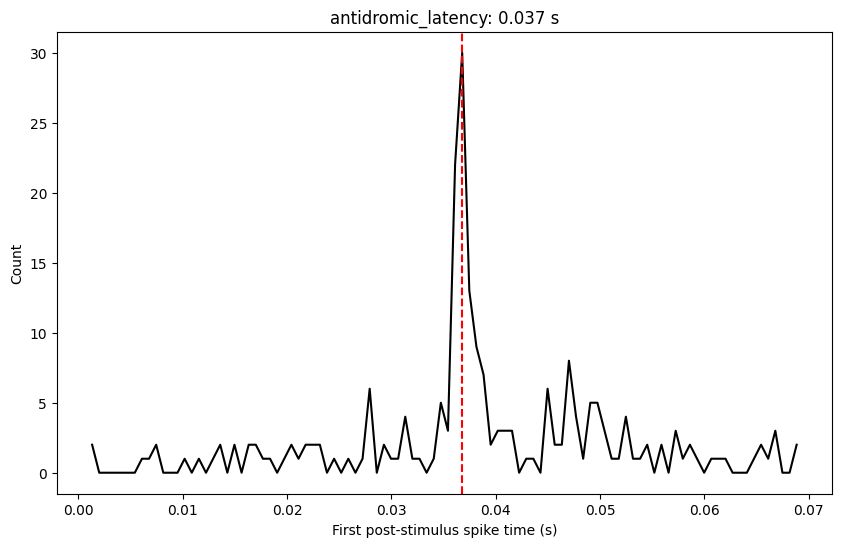

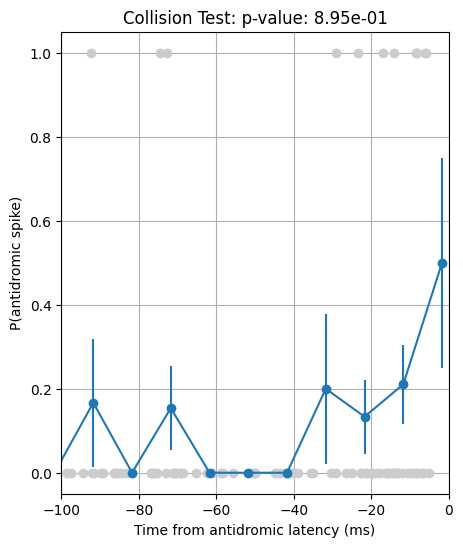

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Assume you already have these ---
# all_spike_times = np.concatenate(ROI_sorted_data)
# antidromic_latency (scalar, in seconds)
# antidromic_jitter = 0.005

# Step 1: Preprocessing
num_trials = len(ROI_sorted_data)
last_ortho_spike_times = np.full(num_trials, np.nan)
collision_flags = np.ones(num_trials, dtype=int)  # Start assuming collision (=1), change later if antidromic spike exists

# antidromic analysis
# ROI_sorted_data = sorted_data 
first_post_stim_spike_times = []
all_spike_times = np.concatenate(ROI_sorted_data)

# sorted_data
for a, spike_times in enumerate(ROI_sorted_data):
    if spike_times.size > 0 and any(spike_times[spike_times > 0]):       
        first_post_stim_spike_times.append(spike_times[spike_times > 0][0])

print(first_post_stim_spike_times)
hist, bin_edges = np.histogram(first_post_stim_spike_times, bins=100)
# plot histogram
plt.figure(figsize=(10, 6))
plt.plot(bin_edges[:-1], hist, color='k')
plt.xlabel('First post-stimulus spike time (s)')
plt.ylabel('Count')
# find x-value for the peak 
peak_x = bin_edges[np.argmax(hist)]
antidromic_latency = peak_x
plt.axvline(peak_x, color='r', linestyle='--')
plt.title(f'antidromic_latency: {peak_x:.3f} s') 




# Step 2: Vectorized processing
for i, spike_times in enumerate(ROI_sorted_data):
    if spike_times.size == 0:
        continue
    
    ortho_mask = spike_times <= (antidromic_latency - antidromic_jitter)
    anti_mask = (antidromic_latency - antidromic_jitter < spike_times) & (spike_times < antidromic_latency + antidromic_jitter)
    
    ortho_spikes = spike_times[ortho_mask]
    anti_spikes = spike_times[anti_mask]
    
    if ortho_spikes.size > 0:
        last_ortho_spike_times[i] = ortho_spikes[-1]  # Only keep the last orthodromic spike
    
    if anti_spikes.size > 0:
        collision_flags[i] = 0  # If antidromic spike exists, collision = 0 (no collision)

# Step 3: Assemble DataFrame
antidromic_df = pd.DataFrame({
    'trial_num': np.arange(num_trials),
    'last_orthodromic_spike_time': last_ortho_spike_times,
    'collision': collision_flags
})

# Step 4: ROI selection and plot
roi_df = antidromic_df.dropna(subset=['last_orthodromic_spike_time'])  # Keep only trials with orthodromic spikes

x = (roi_df['last_orthodromic_spike_time'].values - antidromic_latency) * 1000  # in ms
y = 1 - roi_df['collision'].values  # 1 = successful antidromic spike, 0 = collision

from scipy.stats import mannwhitneyu
# Define windows (you can adjust these)
early_window = (-100, -70)  # in ms
near_latency_window = (-30, 0)

# Select data in each window
early_indices = (x >= early_window[0]) & (x < early_window[1])
near_latency_indices = (x >= near_latency_window[0]) & (x <= near_latency_window[1])

early_probs = y[early_indices]
near_latency_probs = y[near_latency_indices]

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(early_probs, near_latency_probs, alternative='greater')

print(f"Mann-Whitney U test statistic: {statistic:.4f}")


# Interpretation
if p_value < 0.05:
    print("P(antidromic spike) is significantly lower near antidromic latency (p < 0.05).")
else:
    print("No significant decrease in P(antidromic spike) near antidromic latency.")

# Scatter plot
plt.figure(figsize=(5, 6))
plt.plot(x, y, 'o', color=[0.8, 0.8, 0.8], label='Antidromic spikes')

# Bin averages
def Avg_y_over_x(x, y, bin_size):
    edges = np.arange(np.min(x), np.max(x) + bin_size, bin_size)
    x_idx = np.digitize(x, edges) - 1
    bin_centers = (edges[:-1] + edges[1:]) / 2
    avg_y = np.full_like(bin_centers, np.nan, dtype=np.float64)
    sem_y = np.full_like(bin_centers, np.nan, dtype=np.float64)
    
    for i in range(len(bin_centers)):
        bin_y = y[x_idx == i]
        if bin_y.size > 0:
            avg_y[i] = np.nanmean(bin_y)
            sem_y[i] = np.nanstd(bin_y) / np.sqrt(bin_y.size)
    
    avg_df = pd.DataFrame({'x': bin_centers, 'y': avg_y, 'sem': sem_y})
    return avg_df, edges

# Plot binned averages
result, edges = Avg_y_over_x(x, y, bin_size=10)
plt.errorbar(result['x'], result['y'], yerr=result['sem'], fmt='o-', label='Average ± SEM')
plt.xlabel('Time from antidromic latency (ms)')
plt.ylabel('P(antidromic spike)')
plt.title(f'Collision Test: p-value: {p_value:.2e}')  # <- use f-string
plt.xlim([-100, 0])
plt.ylim([-0.05, 1.05])
# plt.legend()
plt.grid(True)
plt.show()

# print('Bin edges:', edges)

# plt.figure(figsize=(6, 4))
# plt.boxplot([early_probs, near_latency_probs], labels=['Early (-100 to -70 ms)', 'Near Latency (-30 to 0 ms)'])
# plt.ylabel('P(antidromic spike)')
# plt.title(f'Statistical Test\np = {p_value:.4e}')
# plt.grid(True)
# plt.show()


Mann-Whitney U test statistic: 1494.0000
P-value: 1.1482e-10
P(antidromic spike) is significantly lower near antidromic latency (p < 0.05).


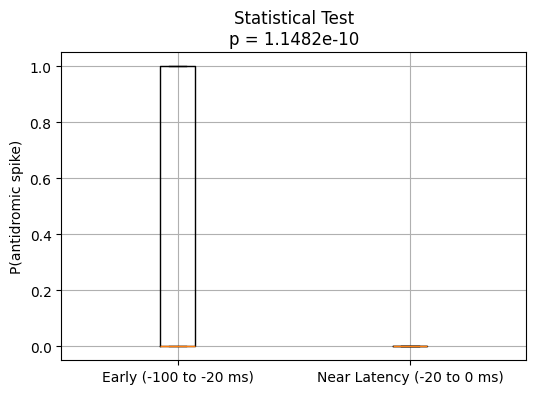